In [36]:
resultsFolderPath = "../../results"

# Results Analysis Notebook


## Steps:
1. Import required libraries
2. Define helper functions for plotting
3. Load and process results data
4. Generate visualizations and statistics

In [37]:
import os
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

# Add parent directory to path to import util module
sys.path.append('..')
from util import readFromCsv

# Configure matplotlib font
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

print("Libraries imported successfully!")

Libraries imported successfully!


## Define Plotting Functions

Custom functions for creating boxplots and bar charts with specific formatting.

In [38]:
def personalizedBoxPlot(data, name, columnNames=None, percentage=False, path=None, show=False, seconds=False, legendInside=False, logscale=False):
    columns = data.columns
    nColumns = len(columns)
    print("Columns:", columns)
    print("Data shape:", data.shape)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    # Creating axes instance
    bp = ax1.boxplot([data[col].dropna().values for col in data.columns],
                 patch_artist=True, notch=True, vert=True)

    colors = plt.cm.Spectral(np.linspace(.1, .9, 3))
    c = np.copy(colors)
    for i in range(nColumns//3):
        c = np.append(c, colors, axis=0)
    colors = c

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # changing color and linewidth of whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#8B008B',
                    linewidth=1.5,
                    linestyle=":")

    # changing color and linewidth of caps
    for cap in bp['caps']:
        cap.set(color='#8B008B',
                linewidth=2)

    # changing color and linewidth of medians
    for median in bp['medians']:
        median.set(color='red',
                   linewidth=3)

    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker='D',
                  color='#e7298a',
                  alpha=0.5)

    if logscale:
        ax1.set_yscale('log')
        
    # x-axis labels
    if columnNames is not None and len(columnNames) > 0:
        nGroups = len(columnNames)
        groupSize = 3  # you have 3 algorithms: NSGA-III, XDA, Anchors
        positions = np.arange(1, nGroups * groupSize + 1)
        centers = [np.mean(positions[i*groupSize:(i+1)*groupSize]) for i in range(nGroups)]
        ax1.set_xticks(centers)
        ax1.set_xticklabels(columnNames)
    else:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # y-axis
    if percentage:
        ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))
        if (data.max().max() - data.min().min())/8 < 0.01:
            ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
    if seconds:
        def y_fmt(x, y):
            return str(int(x)) + ' s' if x >= 1 else str(x) + ' s'
        ax1.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))

    # legend
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    if legendInside:
        ax1.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], ["NSGA-III", "XDA", "Anchors"],)
    else:
        ax1.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], ["NSGA-III", "XDA", "Anchors"],
                   ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))

    # Adding title
    plt.title(name)
    
    # Adding axis labels
    ax1.set_xlabel('Requirements')
    ax1.set_ylabel('Confidence' if 'Confidence' in name else ('Score' if 'Score' in name else 'Time (seconds)'))

    # Removing top axes and right axes ticks
    ax1.get_xaxis().tick_bottom()
    ax1.get_yaxis().tick_left()

    if path is not None:
        plt.savefig(path + name)

    if show:
        plt.show()
    else:
        plt.show()  # Display in notebook
        plt.close()  # Close figure to free memory

print("personalizedBoxPlot function defined")

personalizedBoxPlot function defined


In [39]:
def personalizedBarChart(data, name, path=None, show=False, percentage=False):
    colors = plt.cm.Spectral(np.linspace(.1, .9, 3))
    c = np.copy(colors)
    for i in range(len(data.values) // 3):
        c = np.append(c, colors, axis=0)
    colors = c

    ax = data.plot.bar(title=name, color=colors)

    if len(data.index) > 1:
        plt.xticks(rotation=0)
    else:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    ax.set_ylim(0, 1)
    ax.set_xlabel('Requirements' if len(data.index) > 1 else 'Algorithms')
    ax.set_ylabel('Success Rate')
    if percentage:
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))

    for container in ax.containers:
        if percentage:
            values = ['{:.1%}'.format(v) for v in container.datavalues]
        else:
            values = ['{:.2}'.format(v) for v in container.datavalues]
        ax.bar_label(container, values, fontsize=10)

    if path is not None:
        plt.savefig(path + name)

    if show:
        plt.show()
    else:
        plt.show()  # Display in notebook
        plt.close()  # Close figure to free memory

print("personalizedBarChart function defined")

personalizedBarChart function defined


## Configuration

Set up paths, feature names, and requirements.

In [40]:
pathToResults = resultsFolderPath + "/"

featureNames = ["cruise speed",
                "image resolution",
                "illuminance",
                "controls responsiveness",
                "power",
                "smoke intensity",
                "obstacle size",
                "obstacle distance",
                "firm obstacle"]

reqs = ["req_0", "req_1", "req_2", "req_3"]
reqsNamesInGraphs = ["R1", "R2", "R3", "R4"]

print(f"Configuration complete. Results path: {pathToResults}")

Configuration complete. Results path: ../../results/


## Load Results Data

Read the main results CSV and determine the number of requirements.

In [41]:
# Read dataframe from csv
results = readFromCsv(pathToResults + 'test1.csv')
nReqs = len(results["nsga3_confidence"][0])
reqs = reqs[:nReqs]
reqsNamesInGraphs = reqsNamesInGraphs[:nReqs]
targetConfidence = np.full((1, nReqs), 0.8)[0]

print(f"Loaded {len(results)} results with {nReqs} requirements")
print(f"Requirements: {reqs}")
print(f"Target confidence: {targetConfidence}")


Loaded 1 results with 1 requirements
Requirements: ['req_0']
Target confidence: [0.8]


## Load Outcomes Data

Load the outcomes for each algorithm from separate CSV files.

In [42]:
# Read outcomes from csv
customOutcomes = pd.read_csv(pathToResults + 'customDataset.csv')
nsga3Outcomes = pd.read_csv(pathToResults + 'nsga3Dataset.csv')
anchorsOutcomes = pd.read_csv(pathToResults + 'anchorsDataset.csv')

print(f"Loaded outcomes:")
print(f"  - NSGA-III: {len(nsga3Outcomes)} rows")
print(f"  - XDA: {len(customOutcomes)} rows")
print(f"  - Anchors: {len(anchorsOutcomes)} rows")

Loaded outcomes:
  - NSGA-III: 1 rows
  - XDA: 1 rows
  - Anchors: 1 rows


## Prepare Data for Analysis

Build column indices and organize data into dataframes for visualization.

In [43]:
# Build indices arrays
nsga3ConfidenceNames = ['nsga3_confidence_' + req for req in reqs]
nsga3OutcomeNames = ['nsga3_outcome_' + req for req in reqs]
customConfidenceNames = ['custom_confidence_' + req for req in reqs]
customOutcomeNames = ['custom_outcome_' + req for req in reqs]
anchorsConfidenceNames = ['anchors_confidence_' + req for req in reqs]
anchorsOutcomeNames = ['anchors_outcome_' + req for req in reqs]

# Outcomes dataframe
outcomes = pd.concat([nsga3Outcomes[reqs], customOutcomes[reqs], anchorsOutcomes[reqs]], axis=1)
outcomes.columns = np.array(nsga3OutcomeNames + customOutcomeNames + anchorsOutcomeNames)
outcomes = outcomes[list(sum(zip(nsga3OutcomeNames, customOutcomeNames, anchorsOutcomeNames), ()))]

# Decompose arrays columns into single values columns
nsga3Confidences = pd.DataFrame(results['nsga3_confidence'].to_list(),
                                columns=nsga3ConfidenceNames)
customConfidences = pd.DataFrame(results['custom_confidence'].to_list(),
                                 columns=customConfidenceNames)
anchorsConfidences = pd.DataFrame(results['anchors_confidence'].to_list(),
                                  columns=anchorsConfidenceNames)

# Select sub-dataframes to plot
confidences = pd.concat([nsga3Confidences, customConfidences, anchorsConfidences], axis=1)
confidences = confidences[list(sum(zip(nsga3Confidences.columns, customConfidences.columns, anchorsConfidences.columns), ()))]
scores = results[["nsga3_score", "custom_score", "anchors_score"]]
times = results[["nsga3_time", "custom_time", "anchors_time"]]

print("Data prepared successfully!")
print(f"Confidences shape: {confidences.shape}")
print(f"Outcomes shape: {outcomes.shape}")

Data prepared successfully!
Confidences shape: (1, 3)
Outcomes shape: (1, 3)


## Generate General Comparison Plots

Create boxplots comparing confidences, scores, and execution times across all three algorithms.

Columns: Index(['nsga3_confidence_req_0', 'custom_confidence_req_0',
       'anchors_confidence_req_0'],
      dtype='object')
Data shape: (1, 3)


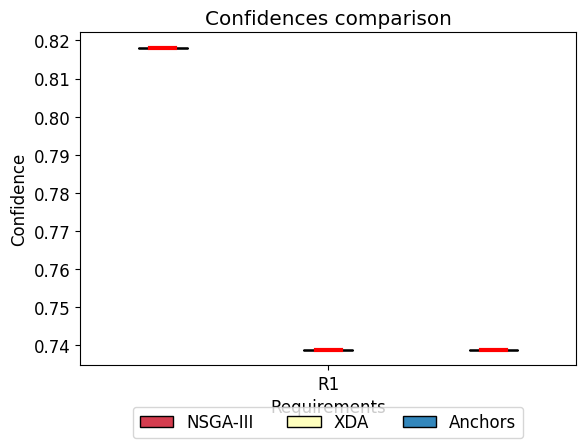

Confidences comparison plot saved
Columns: Index(['nsga3_score', 'custom_score', 'anchors_score'], dtype='object')
Data shape: (1, 3)


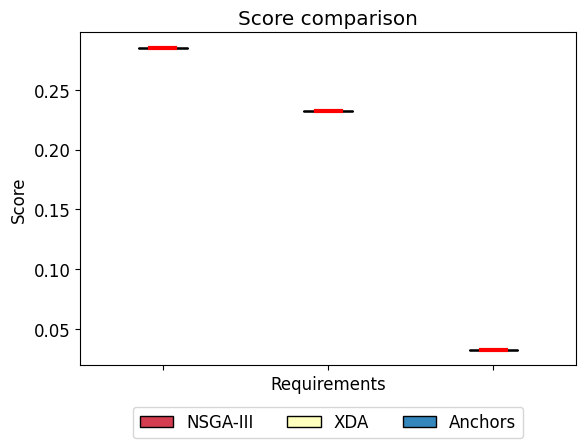

Score comparison plot saved
Columns: Index(['nsga3_time', 'custom_time', 'anchors_time'], dtype='object')
Data shape: (1, 3)


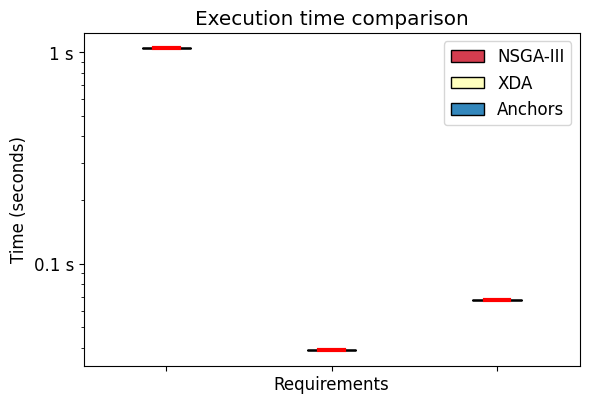

Execution time comparison plot saved


In [44]:
# Create plots directory if it doesn't exist
plotPath = pathToResults + 'plots/'
if not os.path.exists(plotPath):
    os.makedirs(plotPath)
    print(f"Created plots directory: {plotPath}")

# Generate plots
personalizedBoxPlot(confidences, "Confidences comparison", reqsNamesInGraphs, path=plotPath, percentage=False)
print("Confidences comparison plot saved")

personalizedBoxPlot(scores, "Score comparison", path=plotPath)
print("Score comparison plot saved")

personalizedBoxPlot(times, "Execution time comparison", path=plotPath, seconds=True, legendInside=True, logscale=True)
print("Execution time comparison plot saved")

## Predicted Success Analysis

Analyze cases where algorithms predicted successful adaptations (confidence > target threshold).

Columns: Index(['nsga3_confidence_req_0', 'custom_confidence_req_0',
       'anchors_confidence_req_0'],
      dtype='object')
Data shape: (1, 3)


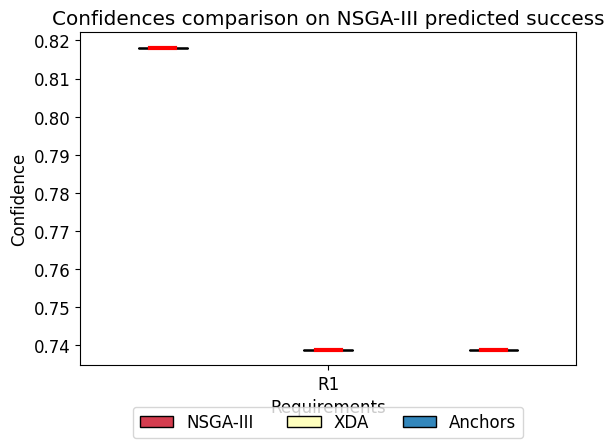

Confidences on NSGA-III predicted success plot saved
Columns: Index(['nsga3_score', 'custom_score', 'anchors_score'], dtype='object')
Data shape: (1, 3)


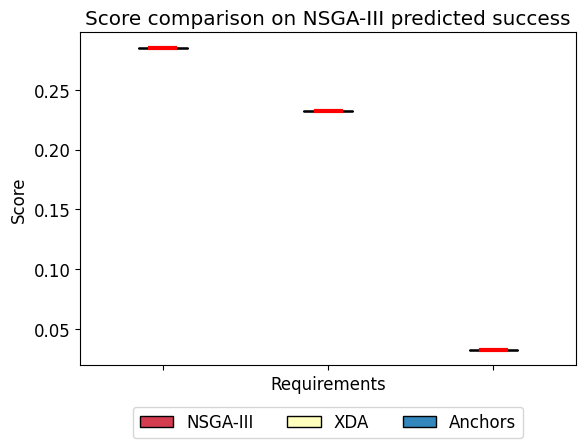

Score on NSGA-III predicted success plot saved
Columns: Index(['nsga3_time', 'custom_time', 'anchors_time'], dtype='object')
Data shape: (1, 3)


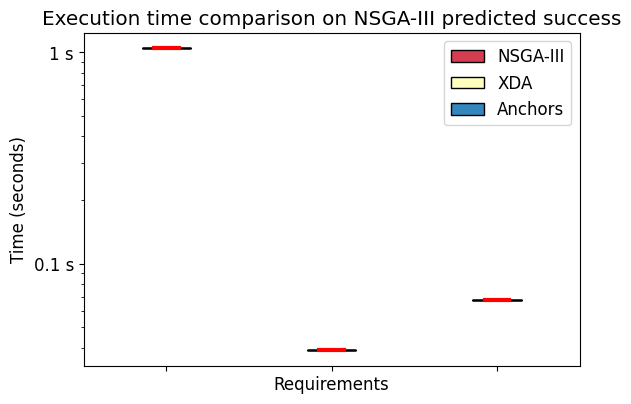

Execution time on NSGA-III predicted success plot saved


In [45]:
# Predicted successful adaptations
nsga3PredictedSuccessful = (confidences[nsga3ConfidenceNames] > targetConfidence).all(axis=1)
customPredictedSuccessful = (confidences[customConfidenceNames] > targetConfidence).all(axis=1)
anchorsPredictedSuccessful = (confidences[anchorsConfidenceNames] > targetConfidence).all(axis=1)

# Generate plots for predicted successful adaptations
personalizedBoxPlot(confidences[nsga3PredictedSuccessful], 
                   "Confidences comparison on NSGA-III predicted success", 
                   reqsNamesInGraphs, path=plotPath, percentage=False)
print("Confidences on NSGA-III predicted success plot saved")

personalizedBoxPlot(scores[nsga3PredictedSuccessful], 
                   "Score comparison on NSGA-III predicted success", 
                   path=plotPath)
print("Score on NSGA-III predicted success plot saved")

personalizedBoxPlot(times[nsga3PredictedSuccessful], 
                   "Execution time comparison on NSGA-III predicted success", 
                   path=plotPath, seconds=True, legendInside=True, logscale=True)
print("Execution time on NSGA-III predicted success plot saved")

## Predicted Success Statistics

Display statistics about predicted successful adaptations.

In [46]:
print("=" * 70)
print("PREDICTED SUCCESS RATES")
print("=" * 70)

print("\nNSGA-III predicted success rate: " + "{:.2%}".format(nsga3PredictedSuccessful.sum() / nsga3PredictedSuccessful.shape[0]))
print(str(nsga3Confidences.mean()) + "\n")

print("XDA predicted success rate:  " + "{:.2%}".format(customPredictedSuccessful.sum() / customPredictedSuccessful.shape[0]))
print(str(customConfidences.mean()) + "\n")

print("Anchors predicted success rate: " + "{:.2%}".format(anchorsPredictedSuccessful.sum() / anchorsPredictedSuccessful.shape[0]))
print(str(anchorsConfidences.mean()) + "\n")

print("-" * 70)
print("MEAN PROBABILITIES OF PREDICTED SUCCESS")
print("-" * 70)

print("\nNSGA-III mean probas of predicted success: \n" + str(nsga3Confidences[nsga3PredictedSuccessful].mean()) + '\n')
print("XDA mean probas of predicted success: \n" + str(customConfidences[customPredictedSuccessful].mean()) + '\n')
print("Anchors mean probas of predicted success: \n" + str(anchorsConfidences[anchorsPredictedSuccessful].mean()) + '\n')

PREDICTED SUCCESS RATES

NSGA-III predicted success rate: 100.00%
nsga3_confidence_req_0    0.818135
dtype: float64

XDA predicted success rate:  0.00%
custom_confidence_req_0    0.738826
dtype: float64

Anchors predicted success rate: 0.00%
anchors_confidence_req_0    0.738826
dtype: float64

----------------------------------------------------------------------
MEAN PROBABILITIES OF PREDICTED SUCCESS
----------------------------------------------------------------------

NSGA-III mean probas of predicted success: 
nsga3_confidence_req_0    0.818135
dtype: float64

XDA mean probas of predicted success: 
custom_confidence_req_0   NaN
dtype: float64

Anchors mean probas of predicted success: 
anchors_confidence_req_0   NaN
dtype: float64



## Actual Outcomes Analysis

Analyze the actual success rates based on outcomes (not predictions).

In [47]:
# Actual successful adaptations based on outcomes
nsga3Successful = outcomes[nsga3OutcomeNames].all(axis=1)
customSuccessful = outcomes[customOutcomeNames].all(axis=1)
anchorsSuccessful = outcomes[anchorsOutcomeNames].all(axis=1)

nsga3SuccessRate = nsga3Successful.mean()
customSuccessRate = customSuccessful.mean()
anchorsSuccessRate = anchorsSuccessful.mean()

print("=" * 70)
print("ACTUAL SUCCESS RATES (BASED ON OUTCOMES)")
print("=" * 70)

print("\nNSGA-III success rate: " + "{:.2%}".format(nsga3SuccessRate))
print(str(outcomes[nsga3OutcomeNames].mean()) + "\n")

print("XDA success rate:  " + "{:.2%}".format(customSuccessRate))
print(str(outcomes[customOutcomeNames].mean()) + "\n")

print("Anchors success rate: " + "{:.2%}".format(anchorsSuccessRate))
print(str(outcomes[anchorsOutcomeNames].mean()) + "\n")

ACTUAL SUCCESS RATES (BASED ON OUTCOMES)

NSGA-III success rate: 100.00%
nsga3_outcome_req_0    1.0
dtype: float64

XDA success rate:  0.00%
custom_outcome_req_0    0.0
dtype: float64

Anchors success rate: 100.00%
anchors_outcome_req_0    1.0
dtype: float64



## Success Rate Visualizations

Generate bar charts showing success rates for individual requirements and overall.

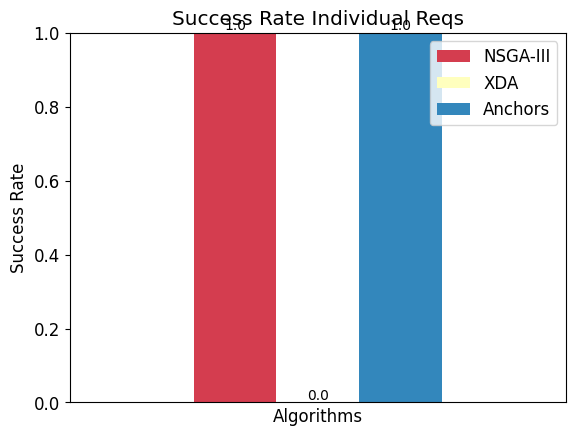

✓ Success Rate Individual Reqs plot saved


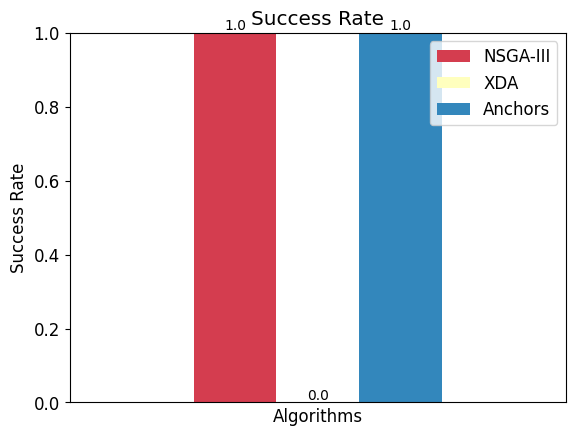

✓ Overall Success Rate plot saved


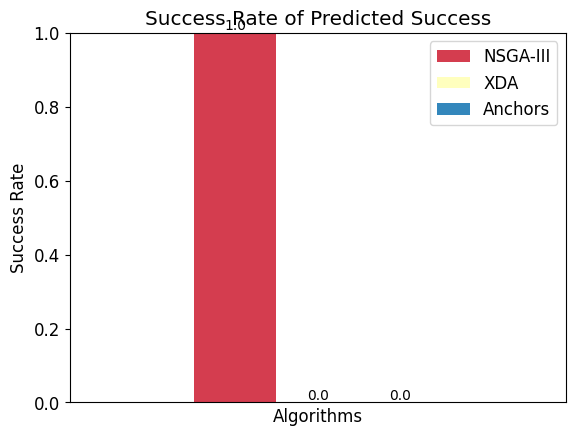

Success Rate of Predicted Success plot saved

ALL PLOTS GENERATED SUCCESSFULLY!
Plots saved to: ../../results/plots/


In [48]:
# Success rate for individual requirements
successRateIndividual = pd.concat([
    outcomes[nsga3OutcomeNames].rename(columns=dict(zip(nsga3OutcomeNames, reqsNamesInGraphs))).mean(),
    outcomes[customOutcomeNames].rename(columns=dict(zip(customOutcomeNames, reqsNamesInGraphs))).mean(),
    outcomes[anchorsOutcomeNames].rename(columns=dict(zip(anchorsOutcomeNames, reqsNamesInGraphs))).mean()
], axis=1)
successRateIndividual.columns = ['NSGA-III', 'XDA', 'Anchors']
personalizedBarChart(successRateIndividual, "Success Rate Individual Reqs", plotPath)
print("✓ Success Rate Individual Reqs plot saved")

# Overall success rate
successRate = pd.DataFrame([[nsga3SuccessRate, customSuccessRate, anchorsSuccessRate]], 
                          columns=["NSGA-III", "XDA", "Anchors"])
personalizedBarChart(successRate, "Success Rate", plotPath)
print("✓ Overall Success Rate plot saved")

# Success rate of predicted success
successRateOfPredictedSuccess = pd.DataFrame([[
    outcomes[nsga3OutcomeNames][nsga3PredictedSuccessful].all(axis=1).mean(),
    outcomes[customOutcomeNames][customPredictedSuccessful].all(axis=1).mean(),
    outcomes[anchorsOutcomeNames][anchorsPredictedSuccessful].all(axis=1).mean()
]], columns=["NSGA-III", "XDA", "Anchors"])
personalizedBarChart(successRateOfPredictedSuccess, "Success Rate of Predicted Success", plotPath)
print("Success Rate of Predicted Success plot saved")

print("\n" + "=" * 70)
print("ALL PLOTS GENERATED SUCCESSFULLY!")
print("=" * 70)
print(f"Plots saved to: {plotPath}")

## Confusion Matrix Analysis

Generate confusion matrices comparing predicted success (confidence > threshold) vs actual outcomes for each algorithm.

- **True Positive (TP)**: Predicted success AND actual success
- **False Positive (FP)**: Predicted success BUT actual failure
- **True Negative (TN)**: Predicted failure AND actual failure
- **False Negative (FN)**: Predicted failure BUT actual success

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

print("Confusion matrix libraries imported!")

Confusion matrix libraries imported!


In [50]:
# Debug: Check shapes of the variables before creating confusion matrices
print("Checking variable shapes:")
print(f"nsga3Successful: {type(nsga3Successful)}, shape/length: {nsga3Successful.shape if hasattr(nsga3Successful, 'shape') else len(nsga3Successful) if hasattr(nsga3Successful, '__len__') else 'scalar'}")
print(f"nsga3PredictedSuccessful: {type(nsga3PredictedSuccessful)}, shape: {nsga3PredictedSuccessful.shape}")
print(f"customSuccessful: {type(customSuccessful)}, shape/length: {customSuccessful.shape if hasattr(customSuccessful, 'shape') else len(customSuccessful) if hasattr(customSuccessful, '__len__') else 'scalar'}")
print(f"customPredictedSuccessful: {type(customPredictedSuccessful)}, shape: {customPredictedSuccessful.shape}")
print(f"anchorsSuccessful: {type(anchorsSuccessful)}, shape/length: {anchorsSuccessful.shape if hasattr(anchorsSuccessful, 'shape') else len(anchorsSuccessful) if hasattr(anchorsSuccessful, '__len__') else 'scalar'}")
print(f"anchorsPredictedSuccessful: {type(anchorsPredictedSuccessful)}, shape: {anchorsPredictedSuccessful.shape}")
print("\nFirst few values:")
print(f"nsga3Successful (first 5): {nsga3Successful.head() if hasattr(nsga3Successful, 'head') else nsga3Successful}")
print(f"nsga3PredictedSuccessful (first 5): {nsga3PredictedSuccessful.head()}")

Checking variable shapes:
nsga3Successful: <class 'pandas.core.series.Series'>, shape/length: (1,)
nsga3PredictedSuccessful: <class 'pandas.core.series.Series'>, shape: (1,)
customSuccessful: <class 'pandas.core.series.Series'>, shape/length: (1,)
customPredictedSuccessful: <class 'pandas.core.series.Series'>, shape: (1,)
anchorsSuccessful: <class 'pandas.core.series.Series'>, shape/length: (1,)
anchorsPredictedSuccessful: <class 'pandas.core.series.Series'>, shape: (1,)

First few values:
nsga3Successful (first 5): 0    True
dtype: bool
nsga3PredictedSuccessful (first 5): 0    True
dtype: bool


In [51]:
def plot_confusion_matrix(y_true, y_pred, algorithm_name, path=None):
    """
    Plot confusion matrix for a given algorithm
    
    Parameters:
    - y_true: actual outcomes (True for success, False for failure)
    - y_pred: predicted outcomes (True for predicted success, False for predicted failure)
    - algorithm_name: name of the algorithm for the title
    - path: path to save the plot
    """
    cm = confusion_matrix(y_true, y_pred, labels=[False, True])
    
    # Ensure we always have a 2x2 matrix even if some classes are missing
    if cm.shape != (2, 2):
        # Create a 2x2 matrix filled with zeros
        cm_full = np.zeros((2, 2), dtype=int)
        # Fill in the available values
        if cm.shape == (1, 1):
            # Only one class present in both true and pred
            if y_true.iloc[0] == False and y_pred.iloc[0] == False:
                cm_full[0, 0] = cm[0, 0]  # TN
            elif y_true.iloc[0] == True and y_pred.iloc[0] == True:
                cm_full[1, 1] = cm[0, 0]  # TP
            elif y_true.iloc[0] == False and y_pred.iloc[0] == True:
                cm_full[0, 1] = cm[0, 0]  # FP
            else:  # y_true == True and y_pred == False
                cm_full[1, 0] = cm[0, 0]  # FN
        cm = cm_full
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Failure', 'Predicted Success'],
                yticklabels=['Actual Failure', 'Actual Success'],
                ax=ax, cbar_kws={'label': 'Count'})
    
    # Add labels and title
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('Actual Label', fontsize=12)
    ax.set_title(f'Confusion Matrix - {algorithm_name}', fontsize=14, fontweight='bold')
    
    # Add performance metrics as text
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics_text = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}'
    ax.text(1.15, 0.5, metrics_text, transform=ax.transAxes, 
            fontsize=11, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if path is not None:
        plt.savefig(path + f'confusion_matrix_{algorithm_name.replace(" ", "_")}')
    
    plt.show()
    plt.close()
    
    return cm, accuracy, precision, recall, f1

print("plot_confusion_matrix function defined")

plot_confusion_matrix function defined


CONFUSION MATRICES

--- NSGA-III ---


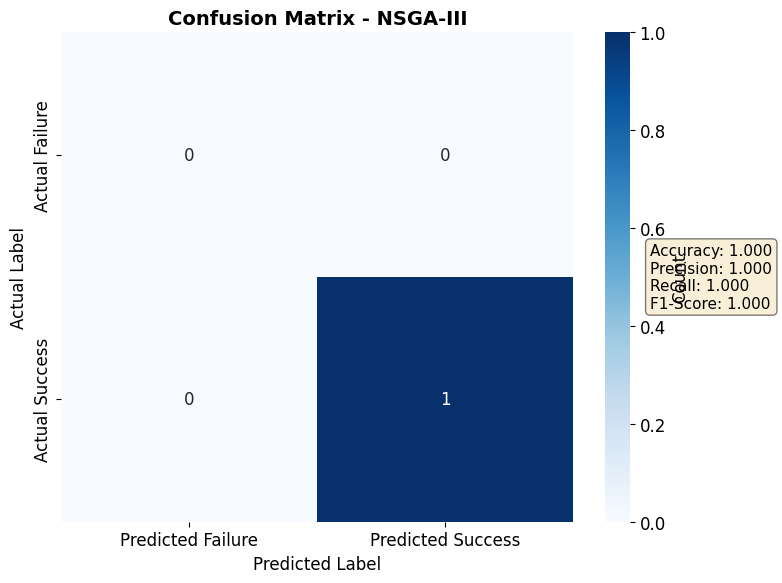

TP: 1, FP: 0, TN: 0, FN: 0
Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1: 1.000

--- XDA ---


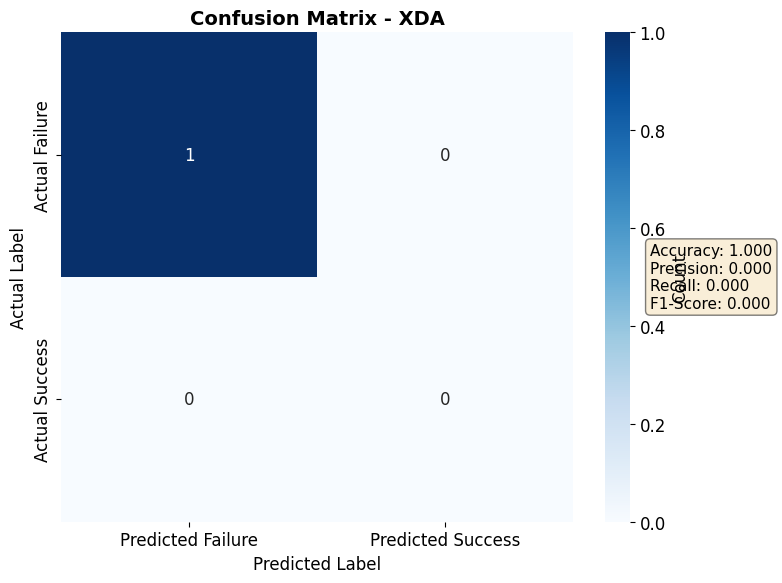

TP: 0, FP: 0, TN: 1, FN: 0
Accuracy: 1.000, Precision: 0.000, Recall: 0.000, F1: 0.000

--- Anchors ---


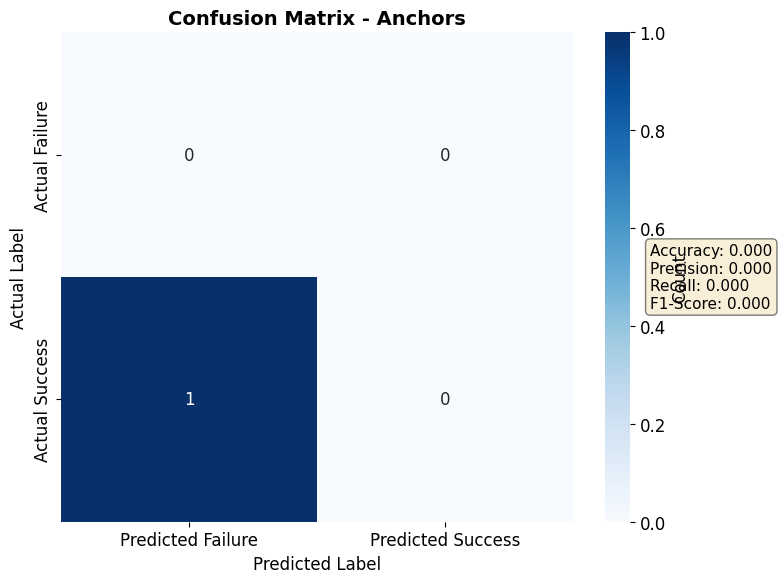

TP: 0, FP: 0, TN: 0, FN: 1
Accuracy: 0.000, Precision: 0.000, Recall: 0.000, F1: 0.000

All confusion matrices generated and saved!


In [52]:
# Generate confusion matrices for each algorithm
print("=" * 70)
print("CONFUSION MATRICES")
print("=" * 70)

# NSGA-III Confusion Matrix
print("\n--- NSGA-III ---")
cm_nsga3, acc_nsga3, prec_nsga3, rec_nsga3, f1_nsga3 = plot_confusion_matrix(
    nsga3Successful, 
    nsga3PredictedSuccessful, 
    'NSGA-III', 
    plotPath
)
print(f"TP: {cm_nsga3[1,1]}, FP: {cm_nsga3[0,1]}, TN: {cm_nsga3[0,0]}, FN: {cm_nsga3[1,0]}")
print(f"Accuracy: {acc_nsga3:.3f}, Precision: {prec_nsga3:.3f}, Recall: {rec_nsga3:.3f}, F1: {f1_nsga3:.3f}")

# XDA (Custom) Confusion Matrix
print("\n--- XDA ---")
cm_custom, acc_custom, prec_custom, rec_custom, f1_custom = plot_confusion_matrix(
    customSuccessful, 
    customPredictedSuccessful, 
    'XDA', 
    plotPath
)
print(f"TP: {cm_custom[1,1]}, FP: {cm_custom[0,1]}, TN: {cm_custom[0,0]}, FN: {cm_custom[1,0]}")
print(f"Accuracy: {acc_custom:.3f}, Precision: {prec_custom:.3f}, Recall: {rec_custom:.3f}, F1: {f1_custom:.3f}")

# Anchors Confusion Matrix
print("\n--- Anchors ---")
cm_anchors, acc_anchors, prec_anchors, rec_anchors, f1_anchors = plot_confusion_matrix(
    anchorsSuccessful, 
    anchorsPredictedSuccessful, 
    'Anchors', 
    plotPath
)
print(f"TP: {cm_anchors[1,1]}, FP: {cm_anchors[0,1]}, TN: {cm_anchors[0,0]}, FN: {cm_anchors[1,0]}")
print(f"Accuracy: {acc_anchors:.3f}, Precision: {prec_anchors:.3f}, Recall: {rec_anchors:.3f}, F1: {f1_anchors:.3f}")

print("\n" + "=" * 70)
print("All confusion matrices generated and saved!")
print("=" * 70)

## Metrics Comparison

Compare classification metrics across all three algorithms.


CLASSIFICATION METRICS COMPARISON
Algorithm  Accuracy  Precision  Recall  F1-Score
 NSGA-III       1.0        1.0     1.0       1.0
      XDA       1.0        0.0     0.0       0.0
  Anchors       0.0        0.0     0.0       0.0



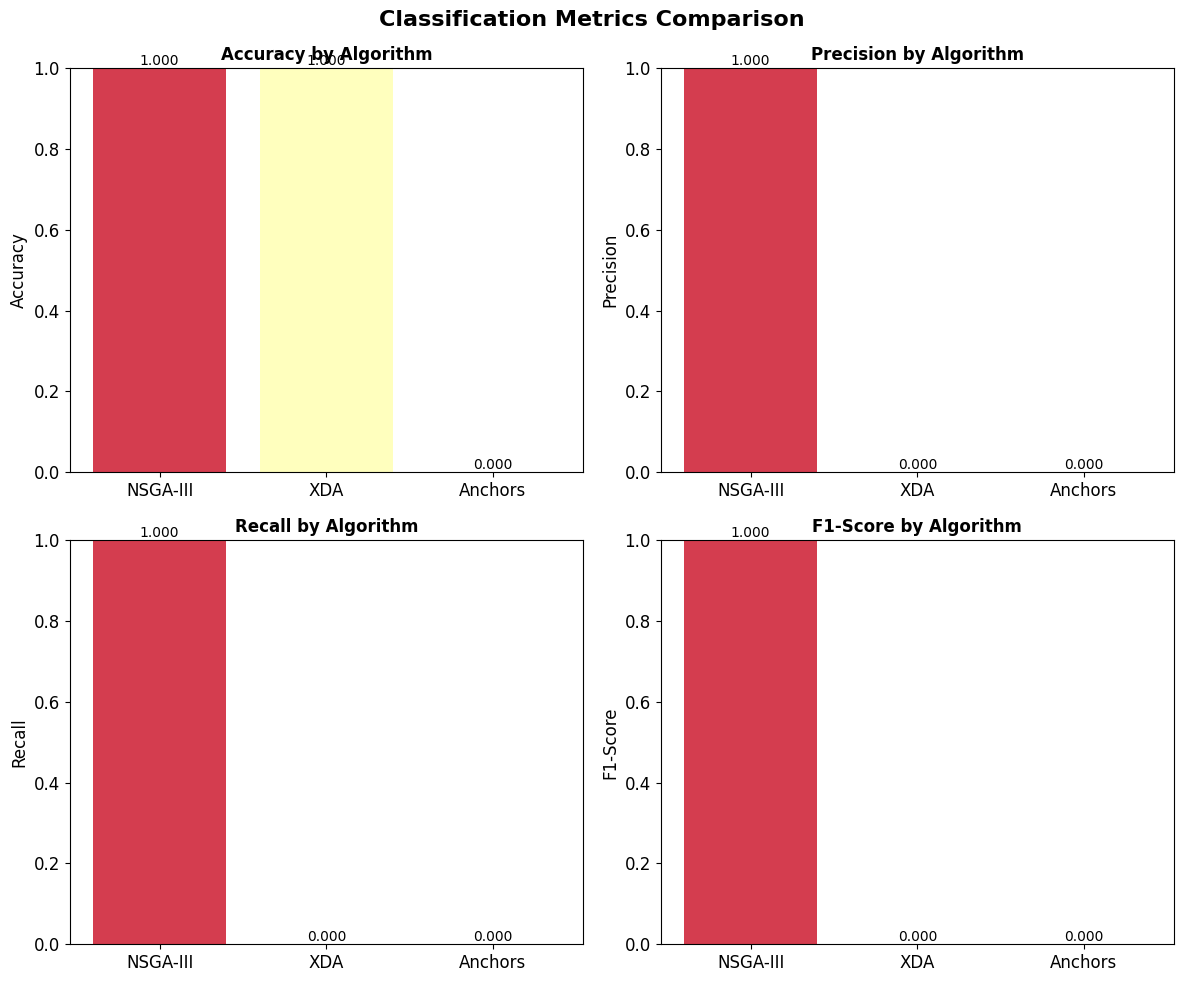

Metrics comparison visualization saved!


In [53]:
# Create comparison table
metrics_df = pd.DataFrame({
    'Algorithm': ['NSGA-III', 'XDA', 'Anchors'],
    'Accuracy': [acc_nsga3, acc_custom, acc_anchors],
    'Precision': [prec_nsga3, prec_custom, prec_anchors],
    'Recall': [rec_nsga3, rec_custom, rec_anchors],
    'F1-Score': [f1_nsga3, f1_custom, f1_anchors]
})

print("\n" + "=" * 70)
print("CLASSIFICATION METRICS COMPARISON")
print("=" * 70)
print(metrics_df.to_string(index=False))
print()

# Visualize metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Classification Metrics Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = plt.cm.Spectral(np.linspace(.1, .9, 3))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(metrics_df['Algorithm'], metrics_df[metric], color=colors)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_title(f'{metric} by Algorithm', fontsize=12, fontweight='bold')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(plotPath + 'metrics_comparison')
plt.show()
plt.close()

print("Metrics comparison visualization saved!")
print("=" * 70)